In [108]:
from d2l import torch as d2l
import torch
import math
import numpy as np
from torch import nn

In [109]:
max_degree = 20

n_train, n_test = 100, 100

true_w = np.zeros(max_degree)

true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))

np.random.shuffle(features)

poly_features = np.power(features, np.arange(max_degree).reshape(1,-1))

for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)

labels = np.dot(poly_features, true_w)

labels += np.random.normal(scale=0.1, size=labels.shape)

In [110]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 0.3537],
         [-1.5092]]),
 tensor([[ 1.0000e+00,  3.5374e-01,  6.2565e-02,  7.3772e-03,  6.5240e-04,
           4.6155e-05,  2.7211e-06,  1.3751e-07,  6.0803e-09,  2.3898e-10,
           8.4536e-12,  2.7185e-13,  8.0136e-15,  2.1806e-16,  5.5096e-18,
           1.2993e-19,  2.8726e-21,  5.9772e-23,  1.1747e-24,  2.1869e-26],
         [ 1.0000e+00, -1.5092e+00,  1.1388e+00, -5.7286e-01,  2.1613e-01,
          -6.5236e-02,  1.6409e-02, -3.5376e-03,  6.6735e-04, -1.1190e-04,
           1.6888e-05, -2.3170e-06,  2.9139e-07, -3.3827e-08,  3.6464e-09,
          -3.6687e-10,  3.4604e-11, -3.0719e-12,  2.5755e-13, -2.0457e-14]]),
 tensor([ 5.1347, -3.8206]))

In [111]:
def evaluate_loss(net, data_iter,loss):

    metric = d2l.Accumulator(2)

    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())

    return metric[0] / metric[1]


def train(train_features, test_features, train_labels, test_labels, num_epochs=400):

    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)), batch_size , is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.0035353  1.2187384 -3.4136264  5.594043 ]]


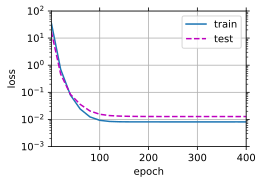

In [112]:
# 从多项式特征中选择前4个维度，即 1, x, x^2/2!, x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[2.7973788 4.7441487]]


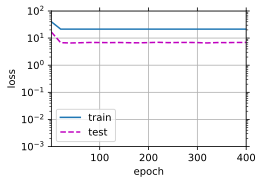

In [113]:
# 从多项式特征中选择前2个维度，即 1, x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 5.006413    1.3003054  -3.438288    5.215199    0.08369288  0.94262636
   0.15373386 -0.14150773 -0.00701059 -0.153414   -0.18994167  0.10165325
  -0.16686444 -0.08867835  0.11862215  0.11757093  0.01711079  0.14589061
   0.18233137 -0.14720722]]


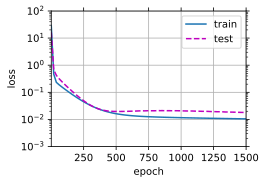

In [114]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)